# Expected Goals Model
My attempt at modeling the expected number of goals for skaters/goalies. In addition to features other models have integrated, such as [change in shot angle](https://www.moneypuck.com/about.htm), this model includes goaltender days of rest, number and direction of timezones traveled through since previous game, and shooter/goalie characteristics (height, weight, handness).  

This notebook contains the following:

* [Loading Data](#1)
* [Data Mining](#2)
* [Feature engineering](#3)
* [Exploratory Data Analysis](#4)
    * [Shot Timeline and Shot Outcome](#4.1)
    * [Shot Location and Shot Outcome](#4.2)
    * [Change in Shot Angle vs Shot Outcome](#4.3)
    * [Change in Timezone and Effect on Shot Outcome ](#4.4)
    * [Shot Type and Shot Outcome](#4.5)
* [Model Building](#5)
    * [Test-Train-Split](#5.1)
    * [Model Training](#5.2)
    * [Model Testing](#5.3)
* [Final Model and Comparison](#6)

TOC

In [1]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### Loading Data <a class="anchor" id="1"></a>

We will load the data from an AWS S3 bucket. This will allow analysis to be reproduced without lengthy data mining steps.

In [2]:
year = '2019'
path = '../../nhl_overtime_eda/data/' + year + '_regSeasonPlays.json'

games = {}
with open(path) as f:
    games[year] = json.load(f)

In [3]:
# year = '2020'
# years = ['2015','2016','2017','2018','2019','2020']
years = ['2019']
games = {}
for year in years:
    path = '../../nhl_overtime_eda/data/' + year + '_regSeasonPlays.json'
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

../../nhl_overtime_eda/data/2019_regSeasonPlays.json


In [4]:
# g = games['2019']['2019020001']

# get game data for 2019-20
game_data = games['2019']

In [5]:
# for game_id in game_data:
#     events = game_data[game_id]
#     break
    
# for event in events['events']:
#     print(event.get('result').get('strength').get('name'))

In [6]:
# for key in games['2019']['2019020001']:
#     print(key)
#     print(games['2019']['2019020001'][key])

In [7]:
# for i in games['2019']['2019020001']['events']:
#     pprint.pprint(i)

### Data mining <a class="anchor" id="2"></a>

Now it is time to parse the raw json data structures for the information we care about, shots! 

In [8]:
# # for game_id in game_data:
# for e in game_data['2019020001']['events']:
#     if e['result']['event'] == 'Shot':
#         pprint.pprint(e)
#         print()

In [9]:
# get information we care about: shots and goals
shots = []
for game_id in game_data:
    home_team = game_data[game_id]['home_team']
    away_team = game_data[game_id]['away_team']
    for event in game_data[game_id]['events']:
        # if event is shot or goal, save it
        if event['result']['event'] == 'Shot' or event['result']['event'] == 'Goal':
            shooter = ''
            shooter_id = 0
            goalie = ''
            goalie_id = 0

            # extract shooter/goalie
            for player in event['players']:
                if player['playerType'] == 'Shooter' or player['playerType'] == 'Scorer':
                    shooter = player['player']['fullName']
                    shooter_id = player['player']['id']
                elif player['playerType'] == 'Goalie':
                    goalie = player['player']['fullName']
                    goalie_id = player['player']['id']
                    
            # extract shooter/goalie team
            shooter_team = event['team']['name']
            goalie_team = home_team
            if goalie_team == shooter_team: goalie_team = away_team

            # extract strength for goal
            strength = 'unknown'
            try:
                strength = event['result']['strength']['name']
            except:
                pass

            shots.append({
                'game_id': game_id,
                'home_team': home_team,
                'away_team': away_team,
                'dateTime': event['about']['dateTime'],
                'period': event['about']['period'],
                'periodTime': event['about']['periodTime'],
                'x_loc': event['coordinates'].get('x', np.NaN),
                'y_loc': event['coordinates'].get('y', np.NaN),
                'shooter': shooter,
                'shooter_id': shooter_id,
                'shooter_team': shooter_team,
                'goalie': goalie,
                'goalie_id': goalie_id,
                'goalie_team': goalie_team,
                'is_goal': (event['result']['event'] == 'Goal'),
                'shot_type': event['result'].get('secondaryType'),                
                'strength': strength
            })

### Feature engineering <a class="anchor" id="3"></a>
* time since last shot (real time and time in period) **records of actual time are inaccurate
* zone where shot came from (high slot, upper slot, etc)
* change of angle since last shot
* change in distance since last shot
* days rest for goaltender
* characteristics of shooter/goalie
    * handness
    * height
    * weight
    * age
* amount of travel since previous game

In [221]:
# convert to dataframe
df = pd.DataFrame(shots)
df = df[df['goalie'] != ''] # filter empty net goals
df = df[df['period'] != 5] # filter shootout attempts


# find total seconds between shots (periodTime)
df['time_seconds'] = df['periodTime'].str[:2].astype(int) * 60 + df['periodTime'].str[3:].astype(int)
df['time_seconds'] = np.where(df['period'] == 2, df['time_seconds'] + 1200, 
                                 np.where(df['period'] == 3, df['time_seconds'] + 2400, df['time_seconds']))
df = df.sort_values(by=['game_id', 'goalie', 'time_seconds']) # sort by game_id and goalie name
df['time_seconds_diff'] = df.groupby(['game_id', 'goalie'])['time_seconds'].diff(1).fillna(df['time_seconds'])

# get total shots
df['tot_shots'] = 1
df['tot_shots'] = df.groupby(['game_id', 'goalie'])['tot_shots'].cumsum()

# fix all shots to one side of ice (adjust x and y coordinates)
df.loc[df['x_loc'] < 0, 'y_loc'] = df['y_loc'] * -1
df['x_loc'] = df['x_loc'].abs()
df = df[df['x_loc'].notna()]

# calculate angle of shot compared to goal
x_goal = 89
df['shot_angle'] = np.where(df['x_loc'] != x_goal,
                            # when shot is from behind the net
                            np.where(df['x_loc'] > x_goal,
                                     np.where(df['y_loc'] >= 0,
                                              round(90 + (90 - np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2),
                                              round(-90 - (90 + np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2)
                                             ),
                                     # when shot is in front of net
                                     round(np.arctan(df['y_loc'] / (x_goal - df['x_loc'])) * (180 / np.pi), 2)
                                    ),
                            # when shot is taken on the goal line
                            np.where(df['y_loc'] >= 0, 90, -90)
                           )

# calculate difference in shot angle
df['shot_angle_prev'] = df.groupby(['game_id', 'goalie'])['shot_angle'].shift(1).fillna(0)
df['shot_angle_diff'] = np.absolute(np.where(df['shot_angle'] < df['shot_angle_prev'],
                                                df['shot_angle'] - df['shot_angle_prev'],
                                                df['shot_angle_prev'] - df['shot_angle']
                                            )
                                   )

# determine if goalie moved to his right since last shot to attempt to make save
df['goalie_move_right'] = np.where(df['shot_angle'] > df['shot_angle_prev'], True, False)

# calculate shot distance to goal
df['shot_dist'] = round(np.sqrt(np.square(df['x_loc'] - x_goal) + np.square(df['y_loc'])), 2)
df['shot_dist_prev'] = df.groupby(['game_id', 'goalie'])['shot_dist'].shift(1).fillna(0)
df['shot_dist_diff'] = df['shot_dist'] - df['shot_dist_prev']

# get days rest for goalie (if at begining of season, just mark days rest as 5)
df_goalies = df[['game_id', 'goalie', 'dateTime']].groupby(['goalie', 'game_id']).first()
df_goalies['dateTime_prev'] = df_goalies['dateTime'].shift(1).fillna('1970-01-01T04:00:00Z')
df_goalies['goalie_days_rest'] = (pd.to_datetime(df_goalies['dateTime']) - pd.to_datetime(df_goalies['dateTime_prev'])).dt.round(freq='D').dt.days
df_goalies['goalie_days_rest'] = np.where(df_goalies['goalie_days_rest'] > 200, 
                                          5, 
                                          np.where(df_goalies['goalie_days_rest'] < 0,
                                                   5,
                                                   df_goalies['goalie_days_rest']
                                                  )
                                         )
df = df.sort_values(by=['goalie', 'game_id']).merge(df_goalies[['goalie_days_rest']], how='left', on=['goalie', 'game_id'])

# get player characteristics (age, height, weight, handness) and merge with dataframe
## characteristics mined in 'player_miner.ipynb'
with open('../data/playerAttributes.json') as f:
    attributes = json.load(f)          # read file
df_atr = pd.DataFrame(attributes)      # convert to df
df_atr.sort_values('id', inplace=True) # sort by id

# merge skater attrs
df_atr_skaters = df_atr[(df_atr['type']=='Forward') | (df_atr['type']=='Defenseman')]    # filter by skaters
df_atr_skaters.columns = [f'shooter_{c}' for c in list(df_atr.columns)]                  # rename columns
df = df.sort_values('shooter_id').merge(df_atr_skaters, how='left', on='shooter_id')     # merge 
df['shooter_age'] = round((pd.to_datetime(df['dateTime'].str[:10]) - 
                           pd.to_datetime(df['shooter_birthDate'])).dt.days / 365, 1)      # calculate age

# merge goalie attrs
df_atr_goalies = df_atr[df_atr['type']=='Goalie']                                   # filter by goalies
df_atr_goalies.columns = [f'goalie_{c}' for c in list(df_atr.columns)]              # rename columns
df = df.sort_values('goalie_id').merge(df_atr_goalies, how='left', on='goalie_id')  # merge 
df['goalie_age'] = round((pd.to_datetime(df['dateTime'].str[:10]) - 
                          pd.to_datetime(df['goalie_birthDate'])).dt.days / 365, 1) # calculate age

# calculate circadian effects (number of timezones crossed since last game)
with open('../data/teamCircadian.json') as f:
    d = json.load(f)          # read file
df_circ = pd.DataFrame(d)      # convert to df
df_circ = df_circ[['game_id', 'team', 'offset_diff']]

# merge skater circadian
df_circ.columns = ['game_id', 'shooter_team', 'shooter_tzTraveled']
df = df.sort_values(['shooter_team', 'game_id']).merge(df_circ, how='left', on=['shooter_team', 'game_id'])

# merge goalie circadian
df_circ.columns = ['game_id', 'goalie_team', 'goalie_tzTraveled']
df = df.sort_values(['goalie_team', 'game_id']).merge(df_circ, how='left', on=['goalie_team', 'game_id'])

# generate dummy vars
df = pd.get_dummies(df, columns=['shot_type', 'shooter_type', 'shooter_shootsCatches', 'goalie_shootsCatches'])

df.head()


,game_id,home_team,away_team,dateTime,period,periodTime,x_loc,y_loc,shooter,shooter_id,...,shot_type_Snap Shot,shot_type_Tip-In,shot_type_Wrap-around,shot_type_Wrist Shot,shooter_type_Defenseman,shooter_type_Forward,shooter_shootsCatches_L,shooter_shootsCatches_R,goalie_shootsCatches_L,goalie_shootsCatches_R
0,2019020012,Anaheim Ducks,Arizona Coyotes,2019-10-04T03:26:26Z,2,12:03,73.0,-28.0,Jason Demers,8474218,...,0,0,0,1,1,0,0,1,1,0
1,2019020012,Anaheim Ducks,Arizona Coyotes,2019-10-04T04:14:09Z,3,07:28,78.0,-23.0,Michael Grabner,8473546,...,0,0,0,0,0,1,1,0,1,0
2,2019020012,Anaheim Ducks,Arizona Coyotes,2019-10-04T02:18:47Z,1,04:11,67.0,12.0,Michael Grabner,8473546,...,0,0,0,1,0,1,1,0,1,0
3,2019020012,Anaheim Ducks,Arizona Coyotes,2019-10-04T04:25:31Z,3,15:38,44.0,27.0,Nick Schmaltz,8477951,...,0,0,0,0,0,1,0,1,1,0
4,2019020012,Anaheim Ducks,Arizona Coyotes,2019-10-04T04:06:19Z,3,03:19,37.0,39.0,Oliver Ekman-Larsson,8475171,...,0,0,0,1,1,0,1,0,1,0


In [222]:
# #### delete columns that are unnecessary ####
# cols_to_drop = ['game_id', 'home_team', 'away_team',
#                 'dateTime', 'period', 'periodTime',
#                 'shooter_team', 'goalie_team', 'strength', 
#                 'shot_angle_prev', 'shot_dist_prev',
#                 'shooter_fullName', 'shooter_birthDate', 'shooter_nationality', 'shooter_primaryPosition',
#                 'goalie_fullName', 'goalie_birthDate', 'goalie_nationality', 
#                 'goalie_primaryPosition', 'goalie_type']
# df = df.drop(cols_to_drop, axis=1)

# #### delete rows with weird data ####
# df = df[df['shooter_height'].isna() == False] # filter rows where it records a goalie shooting puck


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67650 entries, 0 to 67649
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   game_id                  67650 non-null  object 
 1   home_team                67650 non-null  object 
 2   away_team                67650 non-null  object 
 3   dateTime                 67650 non-null  object 
 4   period                   67650 non-null  int64  
 5   periodTime               67650 non-null  object 
 6   x_loc                    67650 non-null  float64
 7   y_loc                    67650 non-null  float64
 8   shooter                  67650 non-null  object 
 9   shooter_id               67650 non-null  int64  
 10  shooter_team             67650 non-null  object 
 11  goalie                   67650 non-null  object 
 12  goalie_id                67650 non-null  int64  
 13  goalie_team              67650 non-null  object 
 14  is_goal               

### Exploratory Data Analysis <a class="anchor" id="4"></a>

##### Shot Timeline and Shot Outcome <a class="anchor" id="4.1"></a>

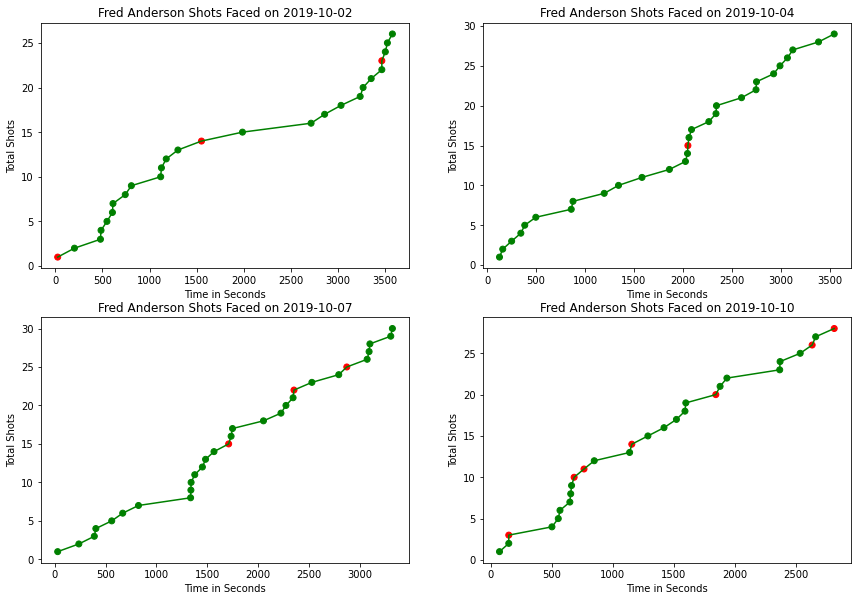

In [381]:
df_tmp = df[df['goalie']=='Frederik Andersen'].sort_values(['game_id', 'time_seconds'])
game_ids = df_tmp['game_id'].unique().tolist()[0:4] # get list of four games

# initiate plots
fig = plt.figure()
subs = [221,222,223,224]

for i in range(0,len(game_ids)):
    df_tmp2 = df_tmp[df_tmp['game_id']==game_ids[i]]
    date = df_tmp2['dateTime'].iloc[0][0:10]
    color = ['red' if goal else 'green' for goal in df_tmp2['is_goal'] ]

    ax=fig.add_subplot(subs[i])
    ax.scatter(df_tmp2['time_seconds'], df_tmp2['tot_shots'], c=color)
    ax.plot(df_tmp2['time_seconds'], df_tmp2['tot_shots'], color='green')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("Time in Seconds")
    plt.ylabel("Total Shots")

plt.subplots_adjust(top=2, right=2)
plt.show()

The above grid of charts shows the time differential between shots, along with goals allowed colored in red. It is imagined that when goalies do not see a shot for some time, they become 'cold' which can cause the next shot to have a higher percentage of beating them. Therefore, we will extract the difference in time between shots faced by goalies as a feature of our model.

##### Shot Location and Shot Outcome <a class="anchor" id="4.2"></a>

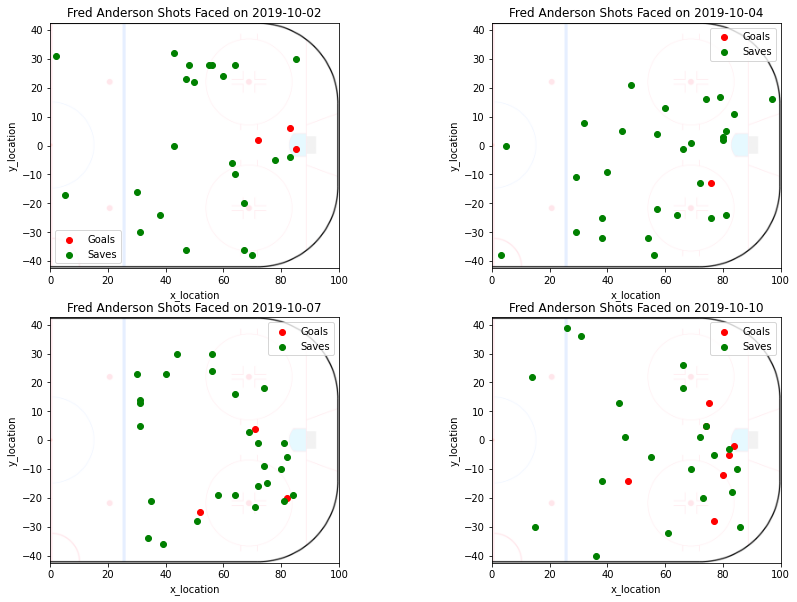

In [382]:
df_tmp = df[df['goalie']=='Frederik Andersen'].sort_values(['game_id', 'time_seconds'])
game_ids = df_tmp['game_id'].unique().tolist()[0:4] # get list of four games

# initiate plots
fig = plt.figure()
subs = [221,222,223,224]

for i in range(0,len(game_ids)):
    df_tmp2 = df_tmp[df_tmp['game_id']==game_ids[i]]
    date = df_tmp2['dateTime'].iloc[0][0:10]

    # read img (retrieved from https://thewincolumn.ca/2021/01/15/r-tutorial-creating-an-nhl-rink-using-the-tidyverse/)
    img = plt.imread("../data/images/nhl_rink_plot_output_light.png")
    ax = fig.add_subplot(subs[i])
    ax.imshow(img, extent=[0, 100, -42.5, 42.5])

    # plot
    goals = ax.scatter(df_tmp2[df_tmp2['is_goal']==True]['x_loc'], 
                        df_tmp2[df_tmp2['is_goal']==True]['y_loc'], 
                        c='red', 
                        label='Goals')
    non_goals = ax.scatter(df_tmp2[df_tmp2['is_goal']==False]['x_loc'], 
                            df_tmp2[df_tmp2['is_goal']==False]['y_loc'], 
                            c='green', 
                            label='Saves')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("x_location")
    plt.ylabel("y_location")
    ax.legend()

plt.subplots_adjust(top=2, right=2)
plt.show()

Above we see charts of shot location and outcome of shot. Shot location is likely the most influential feature of an expected goals model. To add additional detail to shot coordiantes, we will create features to represent the distance of a shot to the net and the angle of a shot (compared to the slot).

##### Change in Shot Angle vs Shot Outcome <a class="anchor" id="4.3"></a>

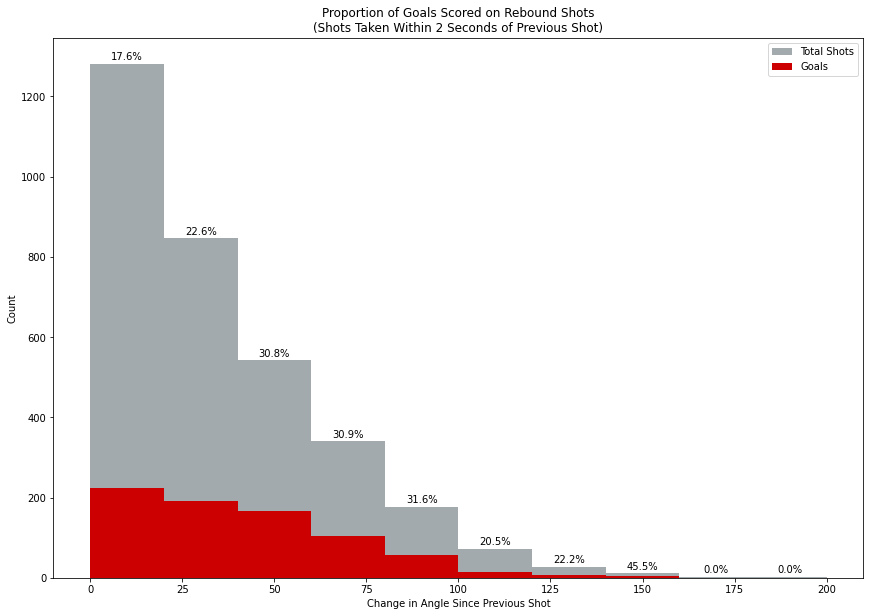

In [388]:
df_rebounds = df[df['time_seconds_diff'] <= 2].copy() # get shots with previous shot taken in past 3 seconds
# df_rebounds = df_rebounds[df_rebounds['goalie'] != ''] # filter empty netters

fig, ax = plt.subplots()

bins = list(np.linspace(0,200,11))
non_goals = plt.hist(df_rebounds['shot_angle_diff'],
                        color='#A2AAAD',
                        label='Total Shots',
                        bins=bins)
goals = plt.hist(df_rebounds[df_rebounds['is_goal'] == True]['shot_angle_diff'],
                color='#CC0000',
                label='Goals',
                bins=bins)

plt.title('Proportion of Goals Scored on Rebound Shots\n(Shots Taken Within 2 Seconds of Previous Shot)')
plt.xlabel("Change in Angle Since Previous Shot")
plt.ylabel("Count")
ax.legend()

# create labels
rects = ax.patches
labels = []
for i in range(len(goals[0])):
    labels.append(round(goals[0][i] / non_goals[0][i] * 100,1))


# apply labels
for rect, label in zip(rects, labels):
    height = rect.get_height()
    text_color = 'black'
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
    
plt.subplots_adjust(top=2, right=2)
plt.show()

Above we see a histogram of change and shot angle and proportion of succesful shots. We see that as we increase the change in angle, the proportion of succesful shots increases. This will certainly be a feature to include in our model.

##### Change in Timezone and Effect on Shot Outcome <a class="anchor" id="4.4"></a>

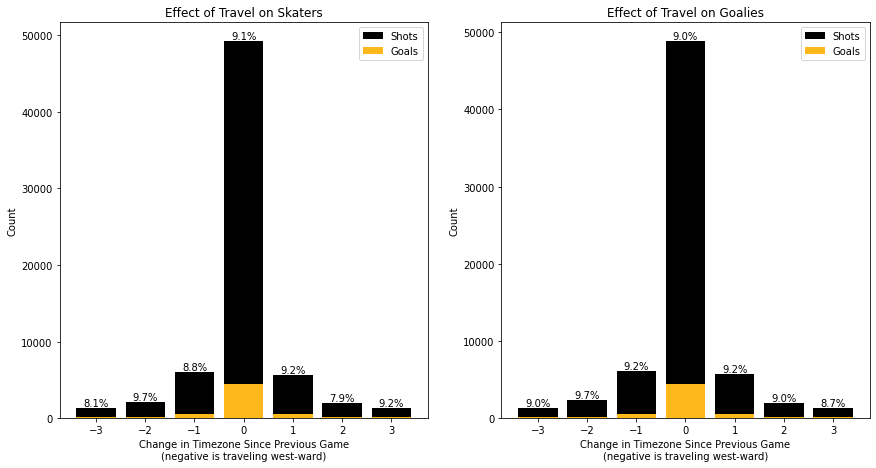

In [384]:
# get timezone differential and number of goals for skaters / number of goals against for goalies 
df_tmp = df[['is_goal', 'shooter_tzTraveled', 'goalie_tzTraveled']].copy() 
df_tmp.groupby('goalie_tzTraveled')['is_goal'].sum()
timezones = sorted(df_tmp['shooter_tzTraveled'].unique())

# extract data as arrays
timezones_skater_shots = df_tmp.groupby('shooter_tzTraveled').size().values
timezones_skater_goals = df_tmp.groupby('shooter_tzTraveled')['is_goal'].sum().values
timezones_goalie_shots = df_tmp.groupby('goalie_tzTraveled').size().values
timezones_goalie_goals = df_tmp.groupby('goalie_tzTraveled')['is_goal'].sum().values

fig = plt.figure()

#### create skater performance plot ###
ax1 = fig.add_subplot(121)
skater_shots = ax1.bar(timezones, timezones_skater_shots,
                color='#000000',
                label='Shots')
skater_goals = ax1.bar(timezones, timezones_skater_goals,
                color='#FFB81C',
                label='Goals')
ax1.legend()
plt.title('Effect of Travel on Skaters')
plt.xlabel("Change in Timezone Since Previous Game\n(negative is traveling west-ward)")
plt.ylabel("Count")

# print goal percentage for each timezone
rects = ax1.patches # create labels
labels = []
for i in range(len(timezones_skater_shots)):
    labels.append(round(timezones_skater_goals[i] / timezones_skater_shots[i] * 100,1))
for rect, label in zip(rects, labels): # apply labels
    height = rect.get_height()
    text_color = 'black'
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
    
    
    
#### create goalie performance plot ####
ax2 = fig.add_subplot(122)
goalie_shots = ax2.bar(timezones, timezones_goalie_shots,
                color='#000000',
                label='Shots')
goalie_goals = ax2.bar(timezones, timezones_goalie_goals,
                color='#FFB81C',
                label='Goals')
ax2.legend()
plt.title('Effect of Travel on Goalies')
plt.xlabel("Change in Timezone Since Previous Game\n(negative is traveling west-ward)")
plt.ylabel("Count")

# print goal percentage for each timezone
rects = ax2.patches # create labels
labels = []
for i in range(len(timezones_goalie_shots)):
    labels.append(round(timezones_goalie_goals[i] / timezones_skater_shots[i] * 100,1))
for rect, label in zip(rects, labels): # apply labels
    height = rect.get_height()
    text_color = 'black'
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)


plt.subplots_adjust(top=1.5, right=2)
plt.show()

Above we see a breakdown of the effects of travel across timezone on skaters' goal scoring ability and goaltenders' puck saving ability. The data is dominated by the class of 'travel between 0 timezones'. Either way, there does not seem to be strong correlation between travel effects and shooting percentage -- at least on the surface. We will allow our models to conclude on the importance of this variable as there might be some interaction effects at play.

##### Shot Type and Shot Outcome <a class="anchor" id="4.5"></a>

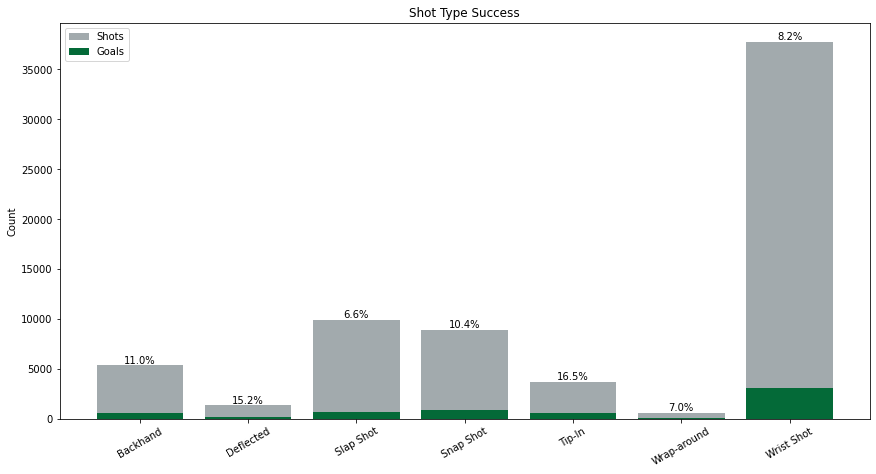

In [386]:
# get goal counts for each type of shot
df_tmp = df[['is_goal', 'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
            'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around', 'shot_type_Wrist Shot']].copy() 

# extract data as arrays
x_labels = ['Backhand', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Shot']
goals = df_tmp[df_tmp['is_goal']].sum()[1:].values
all_shots = df_tmp.sum()[1:].values

fig = plt.figure()

#### create skater performance plot ###
ax1 = fig.add_subplot()
skater_shots = ax1.bar(x_labels, all_shots,
                color='#A2AAAD',
                label='Shots')
skater_goals = ax1.bar(x_labels, goals,
                color='#046A38',
                label='Goals')
ax1.legend()
plt.title('Shot Type Success')
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=30)

# print goal percentage for each timezone
rects = ax1.patches # create labels
labels = []
for i in range(len(goals)):
    labels.append(round(goals[i] / all_shots[i] * 100,1))
for rect, label in zip(rects, labels): # apply labels
    height = rect.get_height()
    text_color = 'black'
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)

plt.subplots_adjust(top=1.5, right=2)
plt.show()

Viewing the shot type success rates, it appears that deflections and tip-ins -- although two of the more uncommon shot types -- are the most succesful. Perhaps this is due to random effects. We will expect our models to rely heavily on shot type as a feature. 

### Model Building <a class="anchor" id="5"></a>

In [54]:
# model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# linear models
from sklearn.linear_model import LinearRegression, 
                                    LogisticRegression, LogisticRegressionCV, 
                                    Ridge, RidgeCV, 
                                    Lasso, LassoCV
            
# tree based models            
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor


# other stuff
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer

##### Test Train Split <a class="anchor" id="5.1"></a>

In [211]:
#### delete columns that are unnecessary ####
cols_to_drop = ['game_id', 'home_team', 'away_team',
                'dateTime', 'period', 'periodTime',
                'shooter_team', 'goalie_team', 'strength', 
                'shot_angle_prev', 'shot_dist_prev',
                'shooter_fullName', 'shooter_birthDate', 'shooter_nationality', 'shooter_primaryPosition',
                'goalie_fullName', 'goalie_birthDate', 'goalie_nationality', 
                'goalie_primaryPosition', 'goalie_type']
df = df.drop(cols_to_drop, axis=1)

#### delete rows with weird data ####
df = df[df['shooter_height'].isna() == False] # filter rows where it records a goalie shooting puck


In [212]:
df_tmp = df.copy()
df_results = df_tmp[['shooter', 'shooter_id', 'goalie', 'goalie_id', 'is_goal']] # use this to score model performance
df_tmp.drop(['shooter', 'shooter_id', 'goalie', 'goalie_id'], axis=1, inplace=True)
y = df_tmp.pop('is_goal')
X = df_tmp.copy()

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# test train split - normalized data
scaler = MinMaxScaler()  # initialize scaler
X_scaled = df_tmp.copy() # copy dataframe
X_scaled[list(X_scaled.columns)] = scaler.fit_transform(X_scaled[list(X_scaled.columns)]) # scale all columns
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X, 
                                                                                y, 
                                                                                test_size=0.3, 
                                                                                random_state=123) # test/train split

###### Model Training <a class="anchor" id="5.2"></a>
* Linear Models
    * Linear Regression
    * Logistic Regression
    * Ridge Regression
    * Lasso Regression
* Tree-Based Models
    * placeholder

In [213]:
def get_rmse(probabilities, shotta, y_test):
    
    # get list of shots tested, add column of shot probability predictions
    df_test = pd.DataFrame(y_test)
    df_test['is_goal_probability'] = probabilities
    df_test.sort_index(inplace=True)

    # join with original dataframe containing skater/goalie names, and shot results
    df_test = df_results[df_results.index.isin(df_test.index)].join(df_test[['is_goal_probability']])

    # get expected goals for each skater
    groups = ['goalie_id', 'goalie']
    if shotta:
        groups = ['shooter_id', 'shooter']
    test_results = df_test.groupby(groups)[['is_goal', 'is_goal_probability']].sum().sort_values('is_goal', ascending=False)
    test_results['error'] = test_results['is_goal_probability'] - test_results['is_goal']
    rmse = np.sqrt(np.mean(np.square(test_results['error'])))
    return rmse

# custom scoring function
def my_custom_loss_func(y_test, y_pred):
    return get_rmse(y_pred, False, y_test)
custom_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

In [214]:
#### linear regression ####

# initiate model
linreg = LinearRegression()

# fit model
linreg.fit(X_train, y_train)

LinearRegression()

In [215]:
#### logistic regression ####

# initiate model
logit = LogisticRegression(max_iter=200)

# fit model
logit.fit(X_train_scaled, y_train_scaled)

/Users/williamshaw/Projects/NHL/nhl_overtime_eda/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [23]:
#### ridge regression ####

# initiate the cross validation over alphas
r_alphas = np.logspace(0, 5, 50)
ridgereg = RidgeCV(cv=5, 
                   alphas=r_alphas, 
                   scoring=custom_scorer)

# fit the model with the best alpha
ridgereg = ridgereg.fit(X_train_scaled, y_train_scaled)

In [88]:
#### lasso regression ####

# initiate the cross validation over alphas
alphas = np.array([5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01, 0.001, 0.0001])
grid = GridSearchCV(estimator=Lasso(), 
                    cv=5,
                    param_grid=dict(alpha=alphas), 
                    scoring=custom_scorer)

# fit the model with the best alpha
lassoreg = grid.fit(X_train_scaled, y_train_scaled)

In [159]:
#### decision tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"criterion": ['squared_error'],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 4, 8, 16, 32],
              "min_samples_leaf": [20],
              "max_leaf_nodes": [5, 20, 100],
              }
grid_dtm = GridSearchCV(DecisionTreeRegressor(random_state = 123), 
                        cv=5,
                        param_grid=param_grid, 
                        scoring=custom_scorer)

# fit the model
grid_dtm = grid_dtm.fit(X_train, y_train)
dtm = grid_dtm.best_estimator_

In [150]:
#### bagged tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [200, 500, 1000],
              "max_features": [1, 2, 3]
              }
grid_bagtm = GridSearchCV(estimator=BaggingRegressor(n_jobs=-1, random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_bagtm = grid_bagtm.fit(X_train, y_train)
bagtm = grid_bagtm.best_estimator_

In [171]:
#### random forest tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [200, 500, 1000],
              "max_depth": [1, 2, 3]
              }
grid_rftm = GridSearchCV(estimator=RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_rftm = grid_rftm.fit(X_train, y_train)
rftm = grid_rftm.best_estimator_

In [172]:
rftm

RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=500,
                      n_jobs=-1, random_state=123)

In [185]:
#### boosted tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [200, 500, 1000],
              "max_depth": [1, 2, 3],
              "alpha": [0.01, 0.1, 0.9, 0.99]
              }
grid_boosttm = GridSearchCV(estimator=GradientBoostingRegressor(max_features='sqrt', random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_boosttm = grid_boosttm.fit(X_train, y_train)
boosttm = grid_boosttm.best_estimator_

In [186]:
boosttm

GradientBoostingRegressor(alpha=0.01, max_depth=2, max_features='sqrt',
                          n_estimators=200, random_state=123)

##### Model Testing <a class="anchor" id="5.3"></a>


In [90]:
def get_shooter_rmse(probabilities, y_test):
    return get_rmse(probabilities, True, y_test)

def get_goalie_rmse(probabilities, y_test):
    return get_rmse(probabilities, False, y_test)

def print_rmse(probabilities, y_test):
    print(f'Skaters RMSE: {get_shooter_rmse(probabilities, y_test)}')
    print(f'Goalies RMSE: {get_goalie_rmse(probabilities, y_test)}\n')


In [91]:
#### Linear Regression Testing ####
pred = linreg.predict(X_test)
print('Linear Regression:')
print_rmse(pred, y_test)

#### Logistic Regression Testing ####
probs = logit.predict_proba(X_test_scaled)
pred = pd.DataFrame(probs)[1].values
print('Logistic Regression:')
print_rmse(pred, y_test_scaled)

#### Ridge Regression Testing ####
pred = ridgereg.predict(X_test_scaled)
print(f'Ridge Regression with alpha={round(ridgereg.alpha_, 2)}:')
print_rmse(pred, y_test_scaled)

#### Lasso Regression Testing ####
pred = lassoreg.predict(X_test_scaled)
print(f'Lasso Regression with alpha={lassoreg.best_estimator_.alpha}:')
print_rmse(pred, y_test_scaled)

Linear Regression:
Skaters RMSE: 1.521962995754401
Goalies RMSE: 5.15361159298436

Logistic Regression:
Skaters RMSE: 1.5697964243087938
Goalies RMSE: 4.910782206272717

Ridge Regression with alpha=1842.07:
Skaters RMSE: 1.528139129485812
Goalies RMSE: 5.145210754969982

Lasso Regression with alpha=0.0005:
Skaters RMSE: 1.5265968424127154
Goalies RMSE: 5.138115849758203



In [188]:
#### Decision Tree Regressor Testing ####
pred = dtm.predict(X_test)
print(f'Decision Tree Regressor')
print_rmse(pred, y_test)

#### Bagged Tree Regressor Testing ####
pred = bagtm.predict(X_test)
print(f'Bagged Tree Regressor')
print_rmse(pred, y_test)

#### Random Forest Tree Regressor Testing ####
pred = rftm.predict(X_test)
print(f'Random Forest Tree Regressor')
print_rmse(pred, y_test)

#### Boosted Tree Regressor Testing ####
pred = boosttm.predict(X_test)
print(f'Boosted Tree Regressor')
print_rmse(pred, y_test)

Decision Tree Regressor
Skaters RMSE: 1.5553747849405002
Goalies RMSE: 4.963484659157325

Bagged Tree Regressor
Skaters RMSE: 1.6546155037303218
Goalies RMSE: 4.972734136930014

Random Forest Tree Regressor
Skaters RMSE: 1.5573718395266187
Goalies RMSE: 4.91311145026268

Boosted Tree Regressor
Skaters RMSE: 1.522290190690305
Goalies RMSE: 4.966133627902857



### Final Model and Comparison <a class="anchor" id="6"></a>